# Sentiment-based product recommendation system
Build a sentiment-based product recommendation system, which includes the following tasks.

- Data sourcing and sentiment analysis
- Building a recommendation system
- Improving the recommendations using the sentiment analysis model
- Deploying the end-to-end project with a user interface

## About the data

- This dataset consists of 30,000 reviews for more than 200 different products. The reviews and ratings are given by more than 20,000 users. Please refer to the following attribute description file to get the details about the columns of the Review Dataset.

## Steps:
1. Import all the libraries
2. Load and analyse data
3. EDA
4. Text Preprocessing
5. TF-IDF vectorization
6. ML models for sentiment classification
    Try below claissification model and select the best model
    - Logistic Regression
    - Random Forest
    - XGBoost
    - Naive Bayes
    - Model evaluation
    - Final model and pickling
7. Recommendation System
    - 7a. User Similarity Matrix
        - Finding the top 20 recommendation for the *user*
        - Evaluation - User User 
    - 7b. Using Item similarity
        - Finding the top 20 recommendation for the *user*
        - Evaluation - Item Item
8. Combining both model and predict top 5 product recommendation for a user      

## 1. Importing Libraries

In [39]:
#general purpose libraries 

import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import warnings
import pickle

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)

In [40]:
# NLTK libraries

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mukul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mukul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mukul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mukul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
# Import Modelling related libraries

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb

In [42]:
#from google.colab import drive
#drive.mount('/content/gdrive')

## 2. Load and analyse data

In [43]:
# Read the dataset

ratings = pd.read_csv("dataset/sample30.csv" , encoding='latin-1')

ratings.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


In [44]:
#Shape of df

print("Shape of dataset:-", ratings.shape)

Shape of dataset:- (30000, 15)


In [45]:
#Column names

print("Columns in DF: ")
print(ratings.columns)

Columns in DF: 
Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'reviews_username', 'user_sentiment'],
      dtype='object')


In [46]:
# Rename some of columns

ratings = ratings.rename(columns={"id": "prod_id", "name": "prod_name"})

In [47]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   prod_id               30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   prod_name             30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [48]:
ratings.dtypes

prod_id                 object
brand                   object
categories              object
manufacturer            object
prod_name               object
reviews_date            object
reviews_didPurchase     object
reviews_doRecommend     object
reviews_rating           int64
reviews_text            object
reviews_title           object
reviews_userCity        object
reviews_userProvince    object
reviews_username        object
user_sentiment          object
dtype: object

### 3. EDA

### Null value analysis

In [49]:
#percentage of null value in each columns

round(ratings.isnull().sum()/len(ratings.index)*100,2)

prod_id                  0.00
brand                    0.00
categories               0.00
manufacturer             0.47
prod_name                0.00
reviews_date             0.15
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.63
reviews_userCity        93.57
reviews_userProvince    99.43
reviews_username         0.21
user_sentiment           0.00
dtype: float64

In [50]:
# calculate the missing count and percentage and create a dataframe (miss_df)

miss_count = ratings.isnull().sum()
miss_percentage = round(miss_count/len(ratings.index)*100,2)

miss_df = pd.DataFrame({'count': miss_count, 'percentage':miss_percentage})
print(miss_df)

                      count  percentage
prod_id                   0        0.00
brand                     0        0.00
categories                0        0.00
manufacturer            141        0.47
prod_name                 0        0.00
reviews_date             46        0.15
reviews_didPurchase   14068       46.89
reviews_doRecommend    2570        8.57
reviews_rating            0        0.00
reviews_text              0        0.00
reviews_title           190        0.63
reviews_userCity      28071       93.57
reviews_userProvince  29830       99.43
reviews_username         63        0.21
user_sentiment            1        0.00


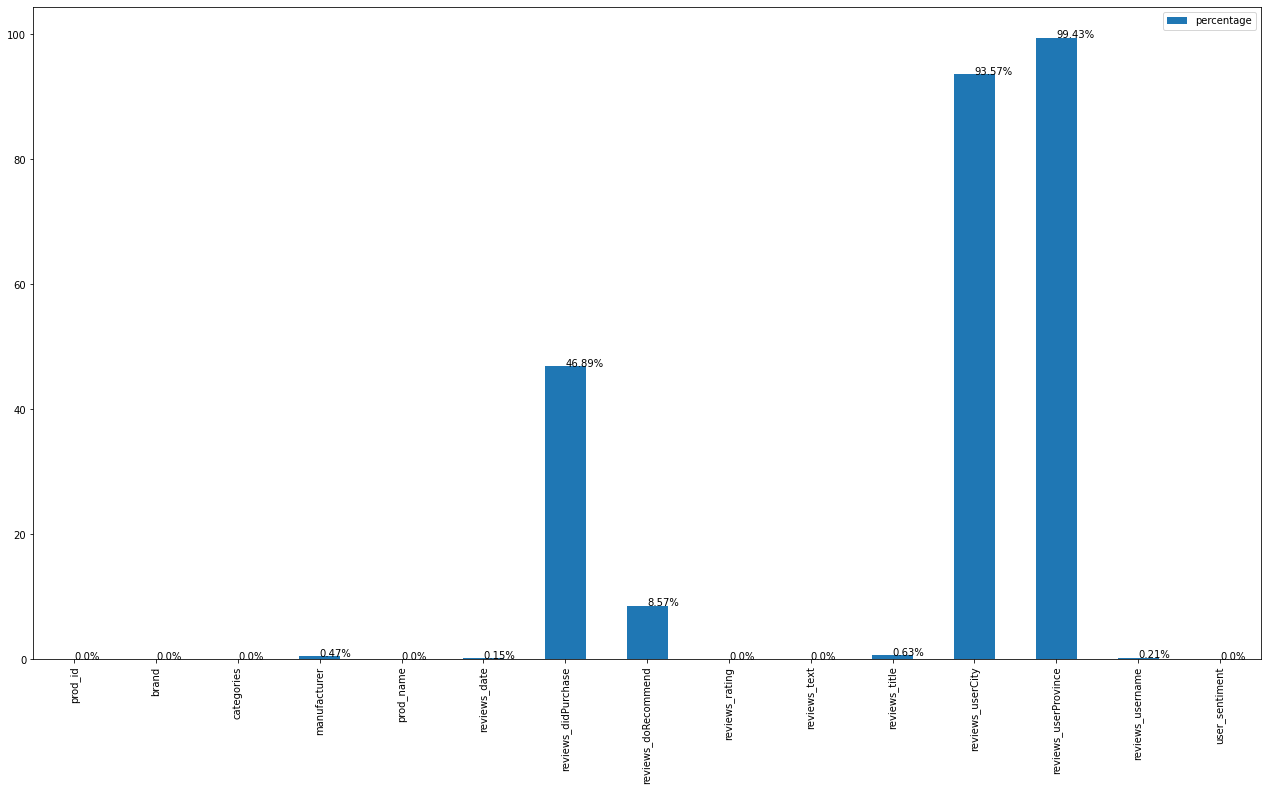

In [51]:
# create barchart for missing value

barchart = miss_df.plot.bar(y='percentage',figsize = (22,12))

for index, percentage in enumerate(miss_percentage):
    barchart.text(index, percentage, str(percentage) + '%' )
    
plt.show()

#### Dropping column having missing value > 90%

In [52]:
#Drop the columns

ratings = ratings.drop(['reviews_userCity', 'reviews_userProvince'], axis =1)

In [53]:
# check the percentage again

round(ratings.isnull().sum()/len(ratings.index)*100,3)

prod_id                 0.000
brand                   0.000
categories              0.000
manufacturer            0.470
prod_name               0.000
reviews_date            0.153
reviews_didPurchase    46.893
reviews_doRecommend     8.567
reviews_rating          0.000
reviews_text            0.000
reviews_title           0.633
reviews_username        0.210
user_sentiment          0.003
dtype: float64

#### reviews_didPurchase is having null value > 40%, but we will not drop the column. Filling the missing value with `na`

In [54]:
# replace the null value with 'na'

ratings.reviews_didPurchase = ratings.reviews_didPurchase.fillna('na')

In [55]:
# For remaning columns drop the rows having null value

ratings = ratings[ratings.reviews_username.notnull()]
ratings = ratings[ratings.reviews_title.notnull()]
ratings = ratings[ratings.manufacturer.notnull()]
ratings = ratings[ratings.user_sentiment.notnull()]
ratings = ratings[ratings.reviews_doRecommend.notnull()]
#ratings.reviews_username = ratings.reviews_username.astype('str')

# reset the index
ratings.reset_index(inplace=True, drop=True)
print('shape of dataset after null value removal:-', ratings.shape)

shape of dataset after null value removal:- (27230, 13)


In [56]:
#Checking the info

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27230 entries, 0 to 27229
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   prod_id              27230 non-null  object
 1   brand                27230 non-null  object
 2   categories           27230 non-null  object
 3   manufacturer         27230 non-null  object
 4   prod_name            27230 non-null  object
 5   reviews_date         27230 non-null  object
 6   reviews_didPurchase  27230 non-null  object
 7   reviews_doRecommend  27230 non-null  object
 8   reviews_rating       27230 non-null  int64 
 9   reviews_text         27230 non-null  object
 10  reviews_title        27230 non-null  object
 11  reviews_username     27230 non-null  object
 12  user_sentiment       27230 non-null  object
dtypes: int64(1), object(12)
memory usage: 2.7+ MB


### `user_sentiment` - column analysis and cleaning 

- I will check whether the user_sentiment have correct value based on ratings.
- assumption is if rating is < 2.5 the sentiments should be negative otherwise positive

In [57]:
ratings.user_sentiment.value_counts()

Positive    24319
Negative     2911
Name: user_sentiment, dtype: int64

In [58]:
print('Value counts for rating greater than 2.5: ')
print(ratings[ratings.reviews_rating > 2.5].user_sentiment.value_counts())

print('Value counts for rating less than 2.5: ')
print(ratings[ratings.reviews_rating < 2.5].user_sentiment.value_counts())

Value counts for rating greater than 2.5: 
Positive    23627
Negative     2427
Name: user_sentiment, dtype: int64
Value counts for rating less than 2.5: 
Positive    692
Negative    484
Name: user_sentiment, dtype: int64


#### The value shown above confirm that user_sentiment is not having correct value. Will set the sentiments as per our assumption.

In [59]:
# if rating is > 2.5 the sentiments should be positive otherwise negative

ratings['user_sentiment'].loc[ratings['reviews_rating'] > 2.5] = 'Positive'
ratings['user_sentiment'].loc[ratings['reviews_rating'] < 2.5] = 'Negative'

In [60]:
print('Value counts for rating greater than 2.5: ')
print(ratings[ratings.reviews_rating > 2.5].user_sentiment.value_counts())

print('Value counts for rating less than equal to 2.5: ')
print(ratings[ratings.reviews_rating < 2.5].user_sentiment.value_counts())

Value counts for rating greater than 2.5: 
Positive    26054
Name: user_sentiment, dtype: int64
Value counts for rating less than equal to 2.5: 
Negative    1176
Name: user_sentiment, dtype: int64


In [61]:
#change the value of user_sentiment to numeric value. Positive - 1, Negative - 0

ratings.user_sentiment = ratings.user_sentiment.map({'Positive': 1, 'Negative': 0})

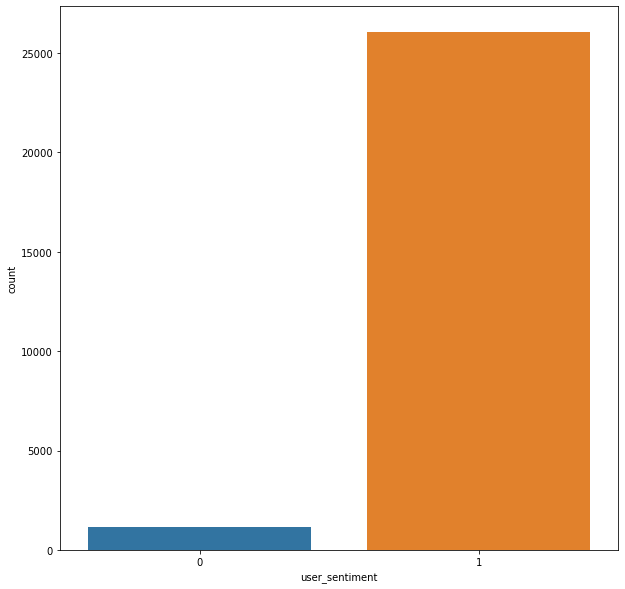

In [62]:
#plotting application data distribution

plt.figure(figsize= (10,10))
sns.countplot(x='user_sentiment', data= ratings)
plt.show()

### Analysis of `reviews_didPurchase`

In [63]:
#Value count for reviews_didPurchase

ratings.reviews_didPurchase.value_counts()

False    14057
na       11760
True      1413
Name: reviews_didPurchase, dtype: int64

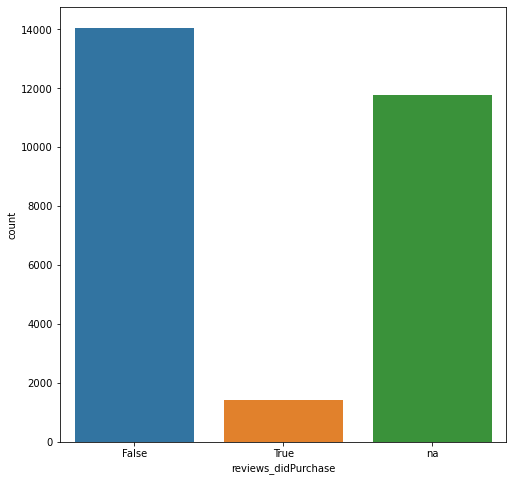

In [64]:
#plotting application data distribution

plt.figure(figsize= (8,8))
sns.countplot(x='reviews_didPurchase', data= ratings)
plt.show()

### Less than 2000 user who has given review has actually purchased the product

Data Distribution


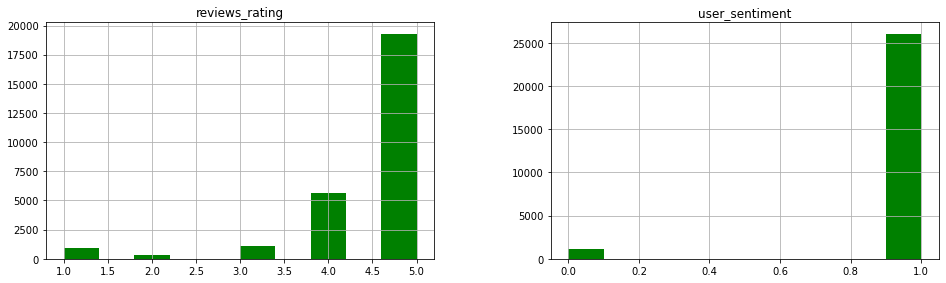

In [65]:
#data distribution:

ratings.hist(layout = (2,2), figsize=(16,10), color = 'g')
print('Data Distribution')

### The dataset is not balanced dataset and negative class is much less than positive class

**Distribution of top 25 reviewed brands**


<AxesSubplot:>

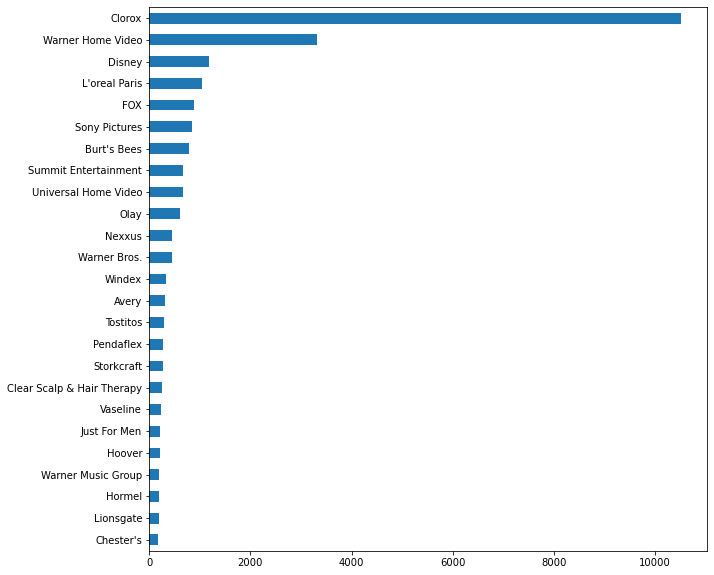

In [66]:
# **Distribution of top 25 reviewed brands**

print('**Distribution of top 25 reviewed brands**')
ratings['brand'].value_counts()[0:25].sort_values().plot(kind = 'barh', figsize=[10,10], fontsize=10)

<AxesSubplot:>

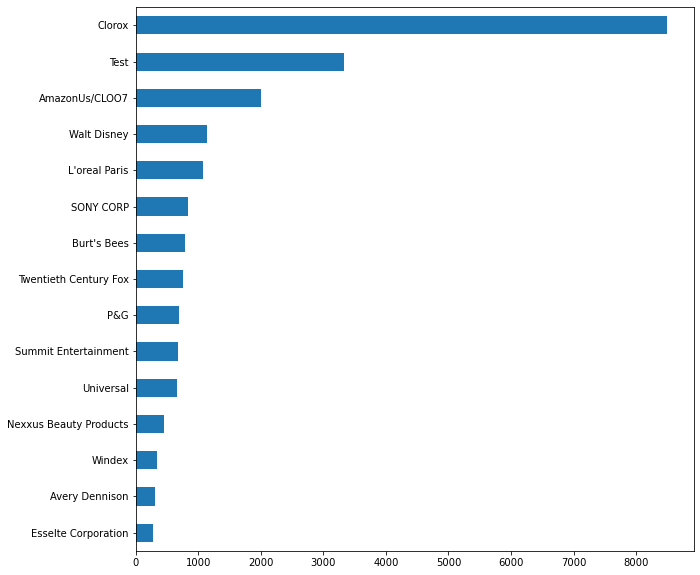

In [67]:
# **Distribution of top 25 manufacturer**

ratings['manufacturer'].value_counts()[0:15].sort_values().plot(kind = 'barh', figsize=[10,10], fontsize=10)

In [68]:
# unique value in the columns

for i in ['brand', 'categories','manufacturer','prod_name','reviews_username','reviews_title', 'reviews_rating']:
  print("No. of unique values in %s is : %s" %(i, ratings[i].nunique()))

No. of unique values in brand is : 163
No. of unique values in categories is : 205
No. of unique values in manufacturer is : 173
No. of unique values in prod_name is : 205
No. of unique values in reviews_username is : 23003
No. of unique values in reviews_title is : 16655
No. of unique values in reviews_rating is : 5


<AxesSubplot:xlabel='count', ylabel='brand'>

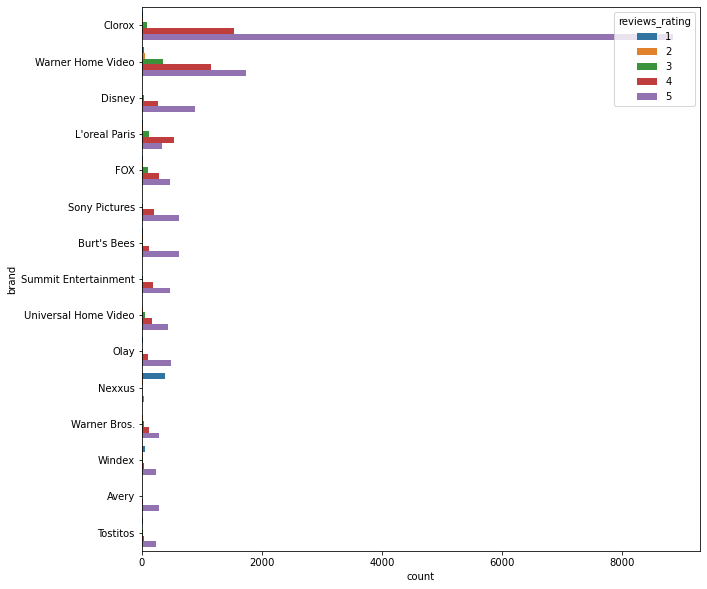

In [69]:
#top 15 brands vs ratings

plt.figure(figsize= (10,10))
sns.countplot(y=ratings['brand'], hue=ratings['reviews_rating'], order=ratings['brand'].value_counts().iloc[:15].index)

## 4. Text Preprocessing

In [70]:
### Combine Review Text and Title into one

ratings['review'] = ratings['reviews_title'] + " " + ratings['reviews_text']

In [71]:
# check the text before test processing

ratings.review[0]

"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess."

In [72]:
#converting into string

ratings['review'] = ratings['review'].astype('str')

#### Remove Stopwords

In [73]:
# Remove Stopwords

stop = stopwords.words('english')
ratings['review'] = ratings['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#### Text cleaning
- remove html markup
- remove punctuation
- remove unneccessary words
- text lowercasing
- remove non-ascii and digits
- #remove whitespace

In [74]:
def scrub_words(text):
    """Basic cleaning of texts."""
    
    # remove html markup
    text=re.sub("(<.*?>)"," ",text)
    
    # Remove punctuation 
    text=re.sub('[^\w\s]','',text)
    
    # remove unneccessary words
    text = text.replace("_"," ")
    
    #text lowercasing 
    text = text.lower()
    
    #remove non-ascii and digits
    text=re.sub("(\\W|\\d)"," ",text)
    
    #remove whitespace
    text = text.strip()
    text = re.sub(' +', ' ',text)
    
    return text

In [75]:
#apply the text processing

ratings['review'] = ratings['review'].apply(lambda x: scrub_words(x))

In [76]:
#print the review text after processing

ratings['review'][0]

'disappointed i read reviews looking buying one couples lubricants ultimately disappointed even live reviews i read for starters neither boyfriend i could notice sort enhanced captivating sensation what notice however messy consistency reminiscent liquidy vaseline it difficult clean up pleasant especially since lacked captivating sensation expecting im disappointed i paid much i lube i use again i could use normal personal lubricant less money less mess'

#### **Lemmatization**

In [77]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [78]:
#define function to wordnet_tag

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [79]:
#define function to lemmatize sentence

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [80]:
#apply word lemmatization

ratings['review'] = ratings['review'].apply(lambda x: lemmatize_sentence(x))

In [81]:
#print after lemmatization

ratings['review'][0]

'disappointed i read review look buy one couple lubricant ultimately disappointed even live review i read for starter neither boyfriend i could notice sort enhanced captivate sensation what notice however messy consistency reminiscent liquidy vaseline it difficult clean up pleasant especially since lack captivate sensation expect im disappoint i pay much i lube i use again i could use normal personal lubricant less money less mess'

#### Word Count

In [82]:
ratings['word_cnt'] = ratings['review'].apply(lambda x: len(str(x).split(" ")))
ratings[['word_cnt','review']].head()

,word_cnt,review
0,66,disappointed i read review look buy one couple lubricant ultimately disappointed even live review i read for starter neither boyfriend i could notice sort enhanced captivate sensation what notice however messy consistency reminiscent liquidy vaseline it difficult clean up pleasant especially sin...
1,17,irritation my husband buy gel us the gel cause irritation felt like burn skin i recommend gel
2,27,not worth my boyfriend i buy spice thing bedroom highly disappointed product we buy one absolutely love ky mine think would similar affect absolutely nothing do buy
3,22,disappoint buy earlier today excite check out base product description i expect something like regular ky we fan expect left little disappointed
4,27,not happy i buy product husband i try impressed all there tingle warm it leave us sticky i use ky product past loved ky hers one disappointing


<AxesSubplot:xlabel='word_cnt', ylabel='Density'>

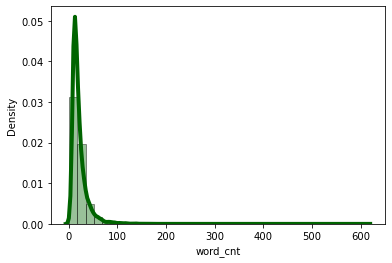

In [83]:
# Density Plot and Histogram of all Word Count

sns.distplot(ratings['word_cnt'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [84]:
ratings.head(2)

,prod_id,brand,categories,manufacturer,prod_name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review,word_cnt
0,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,rebecca,0,disappointed i read review look buy one couple lubricant ultimately disappointed even live review i read for starter neither boyfriend i could notice sort enhanced captivate sensation what notice however messy consistency reminiscent liquidy vaseline it difficult clean up pleasant especially sin...,66
1,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0,irritation my husband buy gel us the gel cause irritation felt like burn skin i recommend gel,17


### Save the clean dataset

In [85]:
#save the update dataset as CSV file

ratings.to_csv('dataset/updated_sample30.csv')

## 5. TF-IDF vectorization

### Read clean df

In [86]:
#Read the clean dataframe

df_new = pd.read_csv("dataset/updated_sample30.csv")

df_new = df_new.drop(['Unnamed: 0'], axis=1)
df_new.head()

,prod_id,brand,categories,manufacturer,prod_name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review,word_cnt
0,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,rebecca,0,disappointed i read review look buy one couple lubricant ultimately disappointed even live review i read for starter neither boyfriend i could notice sort enhanced captivate sensation what notice however messy consistency reminiscent liquidy vaseline it difficult clean up pleasant especially sin...,66
1,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0,irritation my husband buy gel us the gel cause irritation felt like burn skin i recommend gel,17
2,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-04-20T00:00:00.000Z,False,False,1,My boyfriend and I bought this to spice things up in the bedroom and we were both highly disappointed in this product. We bought this one because we absolutely love the ky yours and mine and we thought this would have a similar affect but it did absolutely nothing. Do not buy.,Not worth it,samantha,0,not worth my boyfriend i buy spice thing bedroom highly disappointed product we buy one absolutely love ky mine think would similar affect absolutely nothing do buy,27
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-08T00:00:00.000Z,False,False,1,Bought this earlier today and was excited to check it out. Based on the product description I was expecting something but it was just like the regular KY. We are fans of the his and hers so we just expected more and were left a little disappointed.,Disappointing,raeanne,0,disappoint buy earlier today excite check out base product description i expect something like regular ky we fan expect left little disappointed,22
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-02-21T00:00:00.000Z,False,False,1,I bought this product for my husband and I to try and we were not impressed at all. There was no tingling or warming. It left us both very sticky. I have used KY products in the past (loved KY his and hers) but this one was disappointing.,Not happy at all,kimmie,0,not happy i buy product husband i try impressed all there tingle warm it leave us sticky i use ky product past loved ky hers one disappointing,27


In [87]:
#shape of new dataframe

print('shape of new datafrmae: ', df_new.shape)

shape of new datafrmae:  (27230, 15)


### Define X and y and spliting the data into train and test

In [88]:
# divide into X and y

X=df_new['review'] 
y=df_new['user_sentiment']

In [89]:
# Split the dataset into test and train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
# Tfidf Vectorizer

word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step. 
    analyzer='word',            # Whether the feature should be made of word or character n-grams.
    token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'
    ngram_range=(1, 3),         # The lower and upper boundary of the range of n-values for different n-grams to be extracted
    stop_words='english',
    sublinear_tf=True)

word_vectorizer.fit(X_train)    # Fiting it on Train

TfidfVectorizer(ngram_range=(1, 3), stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [91]:
# now pickle the word vectorizer

pickle.dump(word_vectorizer, open("pickle/vector.pkl", "wb"))

In [92]:
## transforming the train and test datasets
X_train_trans = word_vectorizer.transform(X_train.tolist())
X_test_trans = word_vectorizer.transform(X_test.tolist())

# # Print the shape of each dataset.
print('X_train_transformed', X_train_trans.shape)
print('y_train', y_train.shape)
print('X_test_transformed', X_test_trans.shape)
print('y_test', y_test.shape)

X_train_transformed (21784, 365840)
y_train (21784,)
X_test_transformed (5446, 365840)
y_test (5446,)


## 6. ML models for sentiment classification

### Logistic regression model

In [93]:
# Define a function to check Train and test accuracy score and confusion matrix

def evaluate_model(classifier):
    print("Train Accuracy :", accuracy_score(y_train_sm, classifier.predict(X_train_trans_sm)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train_sm, classifier.predict(X_train_trans_sm)))
    print("*"*50)
    print("Test Accuracy :", accuracy_score(y_test, classifier.predict(X_test_trans)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, classifier.predict(X_test_trans)))
    print("*"*50)
    print("Train classification report:")
    print(classification_report(y_train_sm, classifier.predict(X_train_trans_sm)))
    print("*"*50)
    print("Test classification report:")
    print(classification_report(y_test, classifier.predict(X_test_trans)))

In [94]:
# Build the Logistic Regression model.
start = time.time()

LR1 = LogisticRegression(random_state=42)
LR1.fit(X_train_trans,y_train)

time_taken = time.time() - start
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 2.72 seconds


In [95]:
# Prediction Train Data
y_pred_train= LR1.predict(X_train_trans)

#Model Performance on Train Dataset
print("Logistic Regression accuracy on train set:-", accuracy_score(y_pred_train, y_train))
print(classification_report(y_pred_train, y_train))

Logistic Regression accuracy on train set:- 0.9720437017994858
              precision    recall  f1-score   support

           0       0.36      0.98      0.52       343
           1       1.00      0.97      0.99     21441

    accuracy                           0.97     21784
   macro avg       0.68      0.97      0.75     21784
weighted avg       0.99      0.97      0.98     21784



In [96]:
# Prediction Train Data
y_pred_test= LR1.predict(X_test_trans)

#Model Performance on Train Dataset
print("Logistic Regression accuracy on train set:-", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))

Logistic Regression accuracy on train set:- 0.974293059125964
              precision    recall  f1-score   support

           0       0.42      0.98      0.59       104
           1       1.00      0.97      0.99      5342

    accuracy                           0.97      5446
   macro avg       0.71      0.98      0.79      5446
weighted avg       0.99      0.97      0.98      5446



### There is high class imbalance and that's why the f1 score is so low for negative class.

### Handling class imbalance

In [97]:
# handling class imbalance using smote

counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train_trans_sm, y_train_sm = sm.fit_resample(X_train_trans, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({1: 20848, 0: 936})
After Counter({1: 20848, 0: 20848})


In [98]:
# Building the Logistic Regression model after handling class imbalance
time1 = time.time()

LR2 = LogisticRegression(random_state=42)
LR2.fit(X_train_trans_sm,y_train_sm)

y_pred_test_LR2 = LR2.predict(X_test_trans)

time_taken = time.time() - time1
print('Time Taken in logestic regression with smote: {:.2f} seconds'.format(time_taken))

Time Taken in logestic regression with smote: 3.27 seconds


In [99]:
#evaluate model

evaluate_model(LR2)

Train Accuracy : 0.9987049117421335
Train Confusion Matrix:
[[20847     1]
 [   53 20795]]
**************************************************
Test Accuracy : 0.9728240910760191
Test Confusion Matrix:
[[ 170   70]
 [  78 5128]]
**************************************************
Train classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20848
           1       1.00      1.00      1.00     20848

    accuracy                           1.00     41696
   macro avg       1.00      1.00      1.00     41696
weighted avg       1.00      1.00      1.00     41696

**************************************************
Test classification report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       240
           1       0.99      0.99      0.99      5206

    accuracy                           0.97      5446
   macro avg       0.84      0.85      0.84      5446
weighted avg   

### Random Forest classifier

In [100]:
#Base RF classifier 
time1 = time.time()

RF1 = RandomForestClassifier(random_state=42, n_jobs=-1)
#fit the model

RF1.fit(X_train_trans_sm,y_train_sm)

y_pred_test_RF1 = RF1.predict(X_test_trans)

time_taken = time.time() - time1
print('Time Taken in Random Forest: {:.2f} seconds'.format(time_taken))

Time Taken in Random Forest: 36.97 seconds


In [101]:
evaluate_model(RF1)

Train Accuracy : 0.9999760168841136
Train Confusion Matrix:
[[20848     0]
 [    1 20847]]
**************************************************
Test Accuracy : 0.9722732280572898
Test Confusion Matrix:
[[  92  148]
 [   3 5203]]
**************************************************
Train classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20848
           1       1.00      1.00      1.00     20848

    accuracy                           1.00     41696
   macro avg       1.00      1.00      1.00     41696
weighted avg       1.00      1.00      1.00     41696

**************************************************
Test classification report:
              precision    recall  f1-score   support

           0       0.97      0.38      0.55       240
           1       0.97      1.00      0.99      5206

    accuracy                           0.97      5446
   macro avg       0.97      0.69      0.77      5446
weighted avg   

#### Hyperparameter tuning using grid search CV

In [102]:
# defining parameters - we will use max_depth, min_sample_leaf, n_estimators

params = {
    'max_depth':[15,20,25],
    'min_samples_leaf':[8, 10, 15],
    'n_estimators':[100,200,300]
}

In [103]:
# Use grid search CV with cross validation as 5

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=RF1,
                          param_grid=params,
                          cv=5,
                          n_jobs=-1,
                          verbose=1,
                          scoring='roc_auc')

In [104]:
# fit the model
time1 = time.time()
grid_search.fit(X_train_trans_sm,y_train_sm)

time_taken = time.time() - time1
print('Time Taken in Random Forest using Grid Search CV: {:.2f} seconds'.format(time_taken))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Time Taken in Random Forest using Grid Search CV: 1975.18 seconds


In [105]:
# RF best estimator

rf_best = grid_search.best_estimator_
rf_best


#predict the class
y_pred_test_RF2 = rf_best.predict(X_test_trans)

In [106]:
#evaluate best RF model

evaluate_model(rf_best)

Train Accuracy : 0.8886463929393706
Train Confusion Matrix:
[[16437  4411]
 [  232 20616]]
**************************************************
Test Accuracy : 0.9689680499449137
Test Confusion Matrix:
[[ 112  128]
 [  41 5165]]
**************************************************
Train classification report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     20848
           1       0.82      0.99      0.90     20848

    accuracy                           0.89     41696
   macro avg       0.90      0.89      0.89     41696
weighted avg       0.90      0.89      0.89     41696

**************************************************
Test classification report:
              precision    recall  f1-score   support

           0       0.73      0.47      0.57       240
           1       0.98      0.99      0.98      5206

    accuracy                           0.97      5446
   macro avg       0.85      0.73      0.78      5446
weighted avg   

### XGboost Model

In [107]:
# xgb classifer
time1 = time.time()
XG1 = xgb.XGBClassifier()

XG1.fit(X_train_trans_sm, y_train_sm)

#predict the class
y_pred_test_XG1 = XG1.predict(X_test_trans)

time_taken = time.time() - time1
print('Time Taken in Random Forest using Grid Search CV: {:.2f} seconds'.format(time_taken))

[20:13:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time Taken in Random Forest using Grid Search CV: 68.92 seconds


In [108]:
#evaluate XG boost model

evaluate_model(XG1)

Train Accuracy : 0.993548541826554
Train Confusion Matrix:
[[20640   208]
 [   61 20787]]
**************************************************
Test Accuracy : 0.9752111641571796
Test Confusion Matrix:
[[ 130  110]
 [  25 5181]]
**************************************************
Train classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     20848
           1       0.99      1.00      0.99     20848

    accuracy                           0.99     41696
   macro avg       0.99      0.99      0.99     41696
weighted avg       0.99      0.99      0.99     41696

**************************************************
Test classification report:
              precision    recall  f1-score   support

           0       0.84      0.54      0.66       240
           1       0.98      1.00      0.99      5206

    accuracy                           0.98      5446
   macro avg       0.91      0.77      0.82      5446
weighted avg    

In [109]:
#Hyperparameter tuning using gridsearch CV

from sklearn.model_selection import GridSearchCV

parameters = {'learning_rate': [0.35],
              'max_depth': [8],
              'min_child_weight': [2],
              'n_estimators': [300]}


reg_xgb = GridSearchCV(estimator=XG1,
                       param_grid=parameters,
                       n_jobs=-1,
                       cv=3,
                       refit=True,
                       scoring='roc_auc')
start = time.time()

reg_xgb.fit(X_train_trans_sm,y_train_sm)

time_taken = time.time() - start
print('Time Taken: {:.2f} seconds'.format(time_taken))

[20:20:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time Taken: 503.25 seconds


In [110]:
#best xgb model
xgb_best = reg_xgb.best_estimator_
print(xgb_best)

#predict the class
y_pred_test_XG2 = xgb_best.predict(X_test_trans)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.35, max_delta_step=0, max_depth=8,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


#### Model evaluation

In [111]:
# evaluate the model

evaluate_model(xgb_best)

Train Accuracy : 0.9991126247122026
Train Confusion Matrix:
[[20812    36]
 [    1 20847]]
**************************************************
Test Accuracy : 0.9761292691883952
Test Confusion Matrix:
[[ 128  112]
 [  18 5188]]
**************************************************
Train classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20848
           1       1.00      1.00      1.00     20848

    accuracy                           1.00     41696
   macro avg       1.00      1.00      1.00     41696
weighted avg       1.00      1.00      1.00     41696

**************************************************
Test classification report:
              precision    recall  f1-score   support

           0       0.88      0.53      0.66       240
           1       0.98      1.00      0.99      5206

    accuracy                           0.98      5446
   macro avg       0.93      0.76      0.83      5446
weighted avg   

### Naive Bayes Model

In [112]:
# training the model on training set
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

In [113]:
start = time.time()

# fit

mnb.fit(X_train_trans_sm,y_train_sm)

# predict class
y_pred_test_mnb = mnb.predict(X_test_trans)

time_taken = time.time() - start
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 0.08 seconds


In [114]:
# evaluate the model

evaluate_model(mnb)

Train Accuracy : 0.991749808135073
Train Confusion Matrix:
[[20839     9]
 [  335 20513]]
**************************************************
Test Accuracy : 0.9383033419023136
Test Confusion Matrix:
[[ 193   47]
 [ 289 4917]]
**************************************************
Train classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     20848
           1       1.00      0.98      0.99     20848

    accuracy                           0.99     41696
   macro avg       0.99      0.99      0.99     41696
weighted avg       0.99      0.99      0.99     41696

**************************************************
Test classification report:
              precision    recall  f1-score   support

           0       0.40      0.80      0.53       240
           1       0.99      0.94      0.97      5206

    accuracy                           0.94      5446
   macro avg       0.70      0.87      0.75      5446
weighted avg    

### Model evaluation and Final model

In [115]:
# Build a DataFrame having Accuracy for all the models
models = ['LogisticRegression', 'RandomForest', 'XGBoost', 'NaiveBayes']
model_df = pd.DataFrame(index=range(1*len(models)))

# Accuracy score for Logistic Regression Model
y_train_acc_LR2 = accuracy_score(LR2.predict(X_train_trans_sm), y_train_sm)
y_test_acc_LR2 = accuracy_score(LR2.predict(X_test_trans), y_test)

# Accuracy score for Random Forest Model
y_train_acc_RF2 = accuracy_score(rf_best.predict(X_train_trans_sm), y_train_sm)
y_test_acc_RF2 = accuracy_score(rf_best.predict(X_test_trans), y_test)

# Accuracy score for XGBoost Model
y_train_acc_XG2 = accuracy_score(xgb_best.predict(X_train_trans_sm), y_train_sm)
y_test_acc_XG2 = accuracy_score(xgb_best.predict(X_test_trans), y_test)

# Accuracy score for Naive Bayes Model
y_train_acc_MNB = accuracy_score(mnb.predict(X_train_trans_sm), y_train_sm)
y_test_acc_MNB = accuracy_score(mnb.predict(X_test_trans), y_test)

entries = []

entries.append((models[0],y_train_acc_LR2, y_test_acc_LR2))
entries.append((models[1],y_train_acc_RF2, y_test_acc_RF2))# f1_score_train_RF2, f1_score_test_RF2))
entries.append((models[2],y_train_acc_XG2, y_test_acc_XG2))# f1_score_train_XG2, f1_score_test_XG2))
entries.append((models[3],y_train_acc_MNB, y_test_acc_MNB))

model_df = pd.DataFrame(entries, columns=['Model_Name', 'Train_Accuracy', 'Test_accuracy'])
model_df

,Model_Name,Train_Accuracy,Test_accuracy
0,LogisticRegression,0.998705,0.972824
1,RandomForest,0.888646,0.968968
2,XGBoost,0.999113,0.976129
3,NaiveBayes,0.991750,0.938303


In [116]:
#F1 score of all the models

print('F1-score for all the models: ')
print('LR :', f1_score(y_test, LR2.predict(X_test_trans)))
print('RF :', f1_score(y_test, rf_best.predict(X_test_trans)))
print('XGB:', f1_score(y_test, xgb_best.predict(X_test_trans)))
print('MNB:', f1_score(y_test, mnb.predict(X_test_trans)))

F1-score for all the models: 
LR : 0.9857747020376778
RF : 0.9839032288789408
XGB: 0.9876261184085284
MNB: 0.966961651917404


### Comment about final model
- Logistic Regression and XGBoost test and train accuracy is best. 
- For both of them difference between train and test accuracy is within 3%
- The test data f1_score for negative class (as present in the classification report):
    - for XGboost is 64% 
    - and Logistic regression is 70%

- I will select `Logistic Regression` as my final sentiment classification model.

In [117]:
# now pickle the final model i.e. 'Logistic Regression Model'

pickle.dump(LR2, open("pickle/sentiment_model_LR.pkl", "wb"))

## 7. Recommendation System

- User based recommendation
- User based prediction & evaluation
- Item based recommendation
- Item based prediction & evaluation

### Dividing the dataset into train and test

In [118]:
# Test and Train split of the dataset.

from sklearn.model_selection import train_test_split
train_rc, test_rc = train_test_split(df_new, test_size=0.20, random_state=31)

In [119]:
print(train_rc.shape)
print(test_rc.shape)

(21784, 15)
(5446, 15)


In [120]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.

df_pivot = train_rc.pivot_table(
    index='reviews_username',
    columns='prod_name',
    values='reviews_rating'
).fillna(0)

df_pivot.sample(3)

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,"Heinz Tomato Ketchup, 38oz",Heiress (dvd),Herr's Baked Cheese Curls,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",If A Man Answers (dvd),"Iman Luxury Mo

In [121]:
len(train_rc.reviews_username.value_counts())

18899

In [122]:
len(train_rc.prod_id.value_counts())

198

In [123]:
df_pivot.shape

(18899, 198)

### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [124]:
# Copy the train dataset into dummy_train

dummy_train = train_rc.copy()

In [125]:
# The movies not rated by user is marked as 1 for prediction. 

dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [126]:
# Convert the dummy train dataset into matrix format.

dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='prod_name',
    values='reviews_rating'
).fillna(1)

In [127]:
dummy_train.head()

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,"Heinz Tomato Ketchup, 38oz",Heiress (dvd),Herr's Baked Cheese Curls,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",If A Man Answers (dvd),"Iman Luxury Mo

In [128]:
dummy_train.shape

(18899, 198)

**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different movies.



### 7a. User Similarity Matrix

#### Using Cosine Similarity

In [129]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [130]:
user_correlation.shape

(18899, 18899)

#### Using adjusted Cosine 

#### Here, we are not removing the NaN values and calculating the mean only for the movies rated by the user

In [131]:
# Create a user-movie matrix.
df_pivot = train_rc.pivot_table(
    index='reviews_username',
    columns='prod_name',
    values='reviews_rating'
)

In [132]:
df_pivot.head()

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,"Heinz Tomato Ketchup, 38oz",Heiress (dvd),Herr's Baked Cheese Curls,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",If A Man Answers (dvd),"Iman Luxury Mo

### Normalising the rating of the movie for each user around 0 mean

In [133]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [134]:
df_subtracted.head()

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,"Heinz Tomato Ketchup, 38oz",Heiress (dvd),Herr's Baked Cheese Curls,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",If A Man Answers (dvd),"Iman Luxury Mo

### Finding cosine similarity

In [135]:
from sklearn.metrics.pairwise import pairwise_distances

In [136]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [137]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for movies rated as well as not rated) is the weighted sum of correlation with the movie rating (as present in the rating dataset). 

In [138]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.44485419, 0.        , ..., 4.25484641, 0.42640143,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [139]:
user_predicted_ratings.shape

(18899, 198)

Since we are interested only in the movies not rated by the user, we will ignore the movies rated by the user by making it zero. 

In [140]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head(5)

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,"Heinz Tomato Ketchup, 38oz",Heiress (dvd),Herr's Baked Cheese Curls,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",If A Man Answers (dvd),"Iman Luxury Mo

### Finding the top 20 recommendation for the *user*

In [141]:
# Take the user ID as input.
user_input = input("Enter your user name: ")
print(user_input)

Enter your user name: 00sab00
00sab00


In [142]:
user_final_rating.head(2)

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,"Heinz Tomato Ketchup, 38oz",Heiress (dvd),Herr's Baked Cheese Curls,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",If A Man Answers (dvd),"Iman Luxury Mo

In [143]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

prod_name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd           56.512391
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)       39.584261
The Resident Evil Collection 5 Discs (blu-Ray)                            21.713449
Red (special Edition) (dvdvideo)                                          21.312797
Jason Aldean - They Don't Know                                            11.806114
Hormel Chili, No Beans                                                     9.011886
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                  7.495160
Coty Airspun Face Powder, Translucent Extra Coverage                       6.000000
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)               5.312144
Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)              5.094515
Tostitos Bite Size Tortilla Chips                                          4.640058
100:Complete First Season (blu-Ray)                               

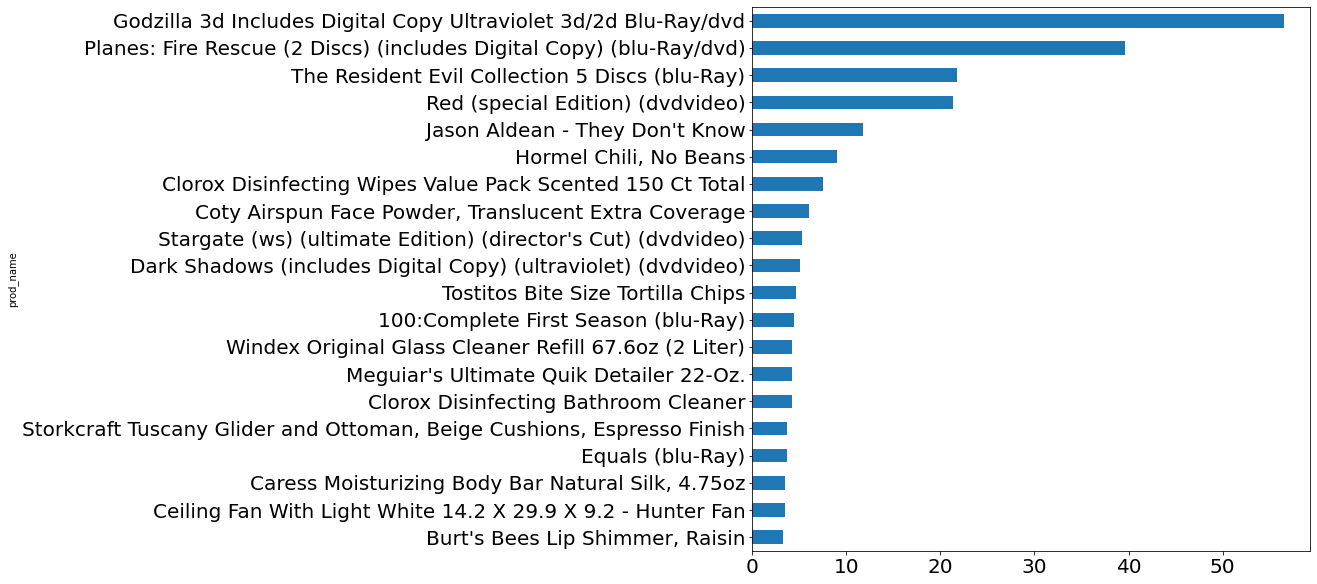

In [144]:
d.plot(kind = 'barh', figsize=[10,10], fontsize=20).invert_yaxis()

In [145]:
d_user = pd.merge(d,df_new,left_on='prod_name',right_on='prod_name',how = 'left').drop_duplicates()

In [146]:
#d = d.loc[d.reviews_username=='00sab00']
d_user.head()

,prod_name,00sab00,prod_id,brand,categories,manufacturer,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review,word_cnt
0,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,56.512391,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",Test,2015-08-05T00:00:00.000Z,na,False,1,could have left this one on the shelf but it had a great box,awful,primoconcept,0,awful could leave one shelf great box,7
1,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,56.512391,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",Test,2015-07-13T00:00:00.000Z,na,False,1,"This movie is much worse that expected. The 1997 Broderick movie is much better. The producers went back to the popular Japanese format that were great for teenagers, but just doesn't work for adults.",Much worse than expected,terrym,0,much bad expect this movie much bad expect the broderick movie much well the producer go back popular japanese format great teenager work adult,24
2,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,56.512391,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",Test,2016-01-29T00:00:00.000Z,na,False,1,"Just don't get the hype about Godzilla. Frankly movie was boring, build up was slow and just not interesting or even worth it. I was even more disappointed to hear Pacific Rim 2 was put on hold for Godzilla vs King Kong if its anything like this movie I'll pass. Oh and because a movie is like th...",Just dont get the hype,mrme,0,just dont get hype just get hype godzilla frankly movie boring build slow interest even worth it i even disappointed hear pacific rim put hold godzilla vs king kong anything like movie ill pas oh movie like original make good time change update story would work new generation,48
3,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,56.512391,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",Test,2016-07-07T00:00:00.000Z,na,False,1,A little disappointed its not like the Godzilla movies years back.,Not the best item,3dknights,0,not best item a little disappointed like godzilla movie year back,11
4,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,56.512391,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",Test,2016-12-02T00:00:00.000Z,na,True,1,"It was on sale, so I bought it. After I got it the case was broken in half witch sucks a lot. But at least the disk are ok I guess. Will not order online if this happens.","Good movie, bad packaging.",master,0,good movie bad packaging it sale i buy it after i get case break half witch suck lot but least disk ok i guess will order online happens,28


### Evaluation - User User 

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user. 

In [147]:
# Find out the common users of test and train dataset.
common = test_rc[test_rc.reviews_username.isin(train_rc.reviews_username)]
common.shape

(1233, 15)

In [148]:
common.head()

,prod_id,brand,categories,manufacturer,prod_name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review,word_cnt
20236,AVpf--o9LJeJML43G_Fq,Vaseline,"Personal Care,Skin Care,Hand Cream,Beauty,Body Lotions & Creams,Featured Brands,Health & Beauty,Unilever,Holiday Shop,Christmas,Bath & Body,Hand Creams & Lotions,Nail Care, Manicure & Pedicure,Hand & Nail Treatment Creams,Moisturizers",Vaseline,Vaseline Intensive Care Healthy Hands Stronger Nails,2015-02-22T00:00:00.000Z,False,True,5,"This is an excellent hand lotion!!! It makes my hands so soft, I carry it everywhere I go and I have some on my desks at work and home. I just wish it came in a larger size like it use to",Excellent Product,belle,1,excellent product this excellent hand lotion it make hand soft i carry everywhere i go i desks work home i wish come large size like use,26
23226,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",Test,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2014-10-18T00:00:00.000Z,na,True,5,The movie and acting was incredibly awesome. Good pick,Great,infamous,1,great the movie act incredibly awesome good pick,8
26491,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,2017-02-01T00:00:00.000Z,False,True,4,I recieved this product from my extraordinary clay voxbox. I really liked the conditioner because it moisturied my hair and has a smooth silky affect. I also love the smell. It's like a tea tree oil. This review was collected as part of a promotion.,Silky smooth hair,ishara,1,silky smooth hair i recieved product extraordinary clay voxbox i really like conditioner moisturied hair smooth silky affect i also love smell its like tea tree oil this review collect part promotion,32
21191,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",Test,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2015-05-17T00:00:00.000Z,na,True,4,"This is a movie of tremendous visual daring, magnificent special effects and surprising moral gravity.",great special effects,batman,1,great special effect this movie tremendous visual daring magnificent special effect surprising moral gravity,14
18706,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & Shower Cleaner,Household Essentials,Cleaning Supplies,Bathroom Cleaners,Prime Pantry,Bathroom,Featured Brands,Home And Storage & Org,Clorox,All-purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Target Restock,Food & Grocery",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2012-01-26T00:00:00.000Z,False,True,5,"I love the convenience of this product, the versatility, and the value! You cannot go wrong with the durable wipes and the versatile thorough cleaning you get with this product. I purchase 4 at a time and put a canister in the kitchen, two bathrooms, and keep the fourth as a back up when I run o...",Use it EVERYWHERE,tee1969,1,use everywhere i love convenience product versatility value you can not go wrong durable wipe versatile thorough cleaning get product i purchase time put canister kitchen two bathroom keep fourth back i run out the best product ever,38


In [149]:
# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='prod_name', values='reviews_rating')

In [150]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [151]:
df_subtracted.head(1)

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,"Heinz Tomato Ketchup, 38oz",Heiress (dvd),Herr's Baked Cheese Curls,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",If A Man Answers (dvd),"Iman Luxury Mo

In [152]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,18799,18800,18801,18802,18803,18804,18805,18806,18807,18808,18809,18810,18811,18812,18813,18814,18815,18816,18817,18818,18819,18820,18821,18822,18823,18824,18825,18826,18827,18828,18829,18830,18831,18832,18833,18834,18835,18836,18837,18838,18839,18840,18841,18842,18843,18844,18845,18846,18847,18848,18849,18850,18851,18852,18853,18854,18855,18856,18857,18858,18859,18860,18861,18862,18863,18864,18865,18866,18867,18868,18869,18870,18871,18872,18873,18874,18875,18876,18877,18878,18879,18880,18881,18882,18883,18884,18885,18886,18887,18888,18889,18890,18891,18892,18893,18894,18895,18896,18897,18898
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [153]:
common.head(1)

,prod_id,brand,categories,manufacturer,prod_name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review,word_cnt
20236,AVpf--o9LJeJML43G_Fq,Vaseline,"Personal Care,Skin Care,Hand Cream,Beauty,Body Lotions & Creams,Featured Brands,Health & Beauty,Unilever,Holiday Shop,Christmas,Bath & Body,Hand Creams & Lotions,Nail Care, Manicure & Pedicure,Hand & Nail Treatment Creams,Moisturizers",Vaseline,Vaseline Intensive Care Healthy Hands Stronger Nails,2015-02-22T00:00:00.000Z,False,True,5,"This is an excellent hand lotion!!! It makes my hands so soft, I carry it everywhere I go and I have some on my desks at work and home. I just wish it came in a larger size like it use to",Excellent Product,belle,1,excellent product this excellent hand lotion it make hand soft i carry everywhere i go i desks work home i wish come large size like use,26


In [154]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [155]:
user_correlation_df_1.shape

(1093, 18899)

In [156]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [157]:
user_correlation_df_3 = user_correlation_df_2.T

In [158]:
user_correlation_df_3.head()

,1234,143st,1943,7inthenest,8ellie24,aaron,abcdefghij,abret,ac94,acg1,actionaction,adma2,adriana9999,aj1135,aj2012,ajackson75,ajeff,ajface24,ajune,akesler19,akhan,alex,alex5514,alexa86,alexis,allan6048,ally,alm27,amandamueller,amber0405,amishmom,amlyke,ammcam,ana79,andrea,andrew,andy,angel,angie,animallover,ann222,annie,annieb,anthony,aphoung,april,arcticfox,arlandry,arno,aros,artfulhousewife,artteacher,as123,ashley,ashley06,ashsmash,ashz131,asnyc,aunt ape,azamy,babe,babygirl,badgrl3616,bailee,bakie,balletdancer83,bananakitty,barbarajean,barbb,bas56,batman,batts,bbbb,bean,beautymaven,beccaruth,becky227,becky25,becky39,beechetu,behair,bella,belle,berly,bestbuyer,bestbuyfan,beth74,betty,bg13,bhemp,bigd,bigdaddy,bigdog,bigdogwood,binniek99,birdman6,bloomingingrace,blt66,blue91,boardwalkempire,...,susie,suzanne,suzybear,suzyq,sweet,sweetie,sweets,sweetwater1856,syms1,taco99,tami,tammy,tammy27,tampa,taratully,tarheelfan,tati2015,tayaktar,taymackk,tb10,teacher,techgeek,tee1969,teecherbabe,teetee,ter86,teresa,terri,terry,thai,thatguy,the office guro,thecorleys2011,thewowfactor,thirsty23,thom,thomas,tiaalese,tierrah,tiff,tiffany1167,tigmommy,timm,timothy,tina,tina71,tink,tjzmom,tman,tmc1,tmouada,tobaira,todd,toni,tony,toot34,tootsie23,topaz0502,toridear,tracy,trpfeffer3,truth,ttdebbi,ttop,turtle,twiggy575,tyreese,ulcunique,val,valentinebarrera,valerie1981,vicki,vicocious,victor,viewer,vivi37,walker,wally,walt,warren,wcgirl,wil27,wind,windowkitty,winniepoo2,wiseman378,wjb1,wolf,wonderwoman,xlivayy,yesseniaw22,yeya,yeyo,ygtz,yohnie1,yorkielvr,yummy,zach,zapman,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.0,0.288675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.447214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,0.0,0.0,0.0,0.0,0.288675,0.204124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.372678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.288675,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.645497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [159]:
user_correlation_df_3.shape

(1093, 1093)

In [160]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.67532195, 0.        ,
        0.28867513],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.28749445, 0.        ,
        0.5       ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [161]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='prod_name', values='reviews_rating').fillna(0)

In [162]:
dummy_test.shape

(1093, 85)

In [163]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [164]:
common_user_predicted_ratings.head(2)

prod_name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""","All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,"Australian Gold Exotic Blend Lotion, SPF 4","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Head & Shoulders Classic Clean Conditioner,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",Jason Aldean - They Don't Know,"Johnson's Baby Bubble Bath and Wash, 15oz",Jolly Time Select Premium Yellow Pop Corn,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,L'oreal Paris Advanced Hairstyle Boost It High Lift Creation Spray,"Lysol Concentrate Deodorizing Cleaner, Original Scent",Meguiar's Deep Crystal Car Wash 64-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Mrs. Meyer's Lemon Verbena Surface Scrub,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nearly Natural 5.5' Bamboo W/decorative Planter,Nearly Natural Pothos Ledge Plant (set On Foam) Silk Plant,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz","Newman's Own Balsamic Vinaigrette, 16.0oz",Nexxus Exxtra Gel Style Creation Sculptor,Olay Regenerist Deep Hydration Regenerating Cream,Orajel Maximum Strength Toothache Pain Relief Liquid,Pantene Pro-V Expert Collection Age Defy Conditioner,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),Pleasant Hearth Diamond Fireplace Screen - Espresso,Power Crunch Protein Energy Bar Peanut Butter Creme Original,Ragu Roasted Garlic Parmesan Pasta Sauce,Ragu Traditional Pasta Sauce,Red (special Edition) (dvdvideo),Sabre 2 Pack Door And Window Alarm,"Shea Moisture Mango & Carrot Kids Extra-Nourishing Conditioner, 8fl Oz","Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",Solo Foods Poppy Seed Cake and Pastry Filling,Sopranos:Season 6 Part 1 (blu-Ray),Spam Single Classic,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",The Resident Evil Collection 5 Discs (blu-Ray),There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tresemme Kertatin Smooth Infusing Conditioning,Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseli

#### Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.

In [165]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [166]:
common_ = common.pivot_table(index='reviews_username', columns='prod_name', values='reviews_rating')

In [167]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [168]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.4912246367166175


### 7b. Using Item similarity

### Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different movie ID. In the user based similarity, we had taken mean for each user instead of each movie. 

In [169]:
df_pivot = train_rc.pivot_table(
    index='reviews_username',
    columns='prod_name',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,09mommy11,1.11E+24,1085,10ten,1143mom,11677j,1234,1234561,1234567,123charlie,123rs,123soccermom,123too,12cass12,12gage,13dani,13ld,13ram,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,170361eggs,1753,17roses,1863philly,1943,1968bear,1970,1979edes,19granny,1boomer,1buzymom,1chynna,1cleaner,1cocoafan,1derpet1,1disappoint,1friendlycat,1gamer,1glenn,1gra,1gussy,1happymom,1healthytot,1jc1,1jodie,1kindword,1movielover2,1okc2thunder3up4,1olaygal,1pleasedclient,1scooby1,1shop,1sonny,1stcavdivision,1stgrade,1stlady,1texasmom,1tomg,1vgarcia,1wildbill2l,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016,2062351337,2175046722,21honey,232323,2532674594,25happyshopper,262jennifer,2689,2827,28green,295259,2athome,2big,2busy4u,2choclabs,2clean4me,2cutekids,2dobies,2esinapod,2iceskates,2low4zero,2rogersmakearight,...,youthfulone,yoyo1245,yozer29,yttric,yucky111,yummy,yunji,yvonne,z12345,z33pisces,z992,zabdelra,zach,zacharymcneill,zacharysaunt,zachizz,zachsmom,zacroxs,zaibo,zak08,zakkwylde29,zakkzakk,zamanda,zanarkandruinsx2,zanay,zanzan73,zapman,zara0215,zarah,zarrahsmommy,zaskar,zburt5,zchandyman,zebrastrong,zee74,zeeleader,zegan,zelyas,zenanuts,zenmon,zer0zer0agent,zeramm,zero,zeroonec,zetamom,zfem2,zhio,zhynellebb,ziana,zibber23,zibby4,ziggy,zillanator,zimmeyb,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippy,zitro,zittles,zkondrk,zman69,zmikez,zmom,zod10,zodness,zoe1988,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zoso60,zout22389,zowie,zozo0o,zpalma,zsarah,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zyiah4,zzz1127
prod_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Normalising the movie rating for each movie for using the Adujsted Cosine

In [170]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [171]:
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,09mommy11,1.11E+24,1085,10ten,1143mom,11677j,1234,1234561,1234567,123charlie,123rs,123soccermom,123too,12cass12,12gage,13dani,13ld,13ram,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,170361eggs,1753,17roses,1863philly,1943,1968bear,1970,1979edes,19granny,1boomer,1buzymom,1chynna,1cleaner,1cocoafan,1derpet1,1disappoint,1friendlycat,1gamer,1glenn,1gra,1gussy,1happymom,1healthytot,1jc1,1jodie,1kindword,1movielover2,1okc2thunder3up4,1olaygal,1pleasedclient,1scooby1,1shop,1sonny,1stcavdivision,1stgrade,1stlady,1texasmom,1tomg,1vgarcia,1wildbill2l,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016,2062351337,2175046722,21honey,232323,2532674594,25happyshopper,262jennifer,2689,2827,28green,295259,2athome,2big,2busy4u,2choclabs,2clean4me,2cutekids,2dobies,2esinapod,2iceskates,2low4zero,2rogersmakearight,...,youthfulone,yoyo1245,yozer29,yttric,yucky111,yummy,yunji,yvonne,z12345,z33pisces,z992,zabdelra,zach,zacharymcneill,zacharysaunt,zachizz,zachsmom,zacroxs,zaibo,zak08,zakkwylde29,zakkzakk,zamanda,zanarkandruinsx2,zanay,zanzan73,zapman,zara0215,zarah,zarrahsmommy,zaskar,zburt5,zchandyman,zebrastrong,zee74,zeeleader,zegan,zelyas,zenanuts,zenmon,zer0zer0agent,zeramm,zero,zeroonec,zetamom,zfem2,zhio,zhynellebb,ziana,zibber23,zibby4,ziggy,zillanator,zimmeyb,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippy,zitro,zittles,zkondrk,zman69,zmikez,zmom,zod10,zodness,zoe1988,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zoso60,zout22389,zowie,zozo0o,zpalma,zsarah,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zyiah4,zzz1127
prod_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Finding the cosine similarity using pairwise distances approach

In [172]:
from sklearn.metrics.pairwise import pairwise_distances

In [173]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ... -0.00584797  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00584797  0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [174]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Prediction - Item Item

In [175]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.01913275, 0.        ,
        0.        ],
       [0.        , 0.03675951, 0.        , ..., 0.00449541, 0.00479146,
        0.        ],
       [0.        , 0.01717206, 0.        , ..., 0.        , 0.00274569,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [176]:
item_predicted_ratings.shape

(18899, 198)

In [177]:
dummy_train.shape

(18899, 198)

### Filtering the rating only for the movies not rated by the user for recommendation

In [178]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

prod_name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin",Calvin Klein Secret Obsession Eau De Parfum,"Candy Pink Plastic Cups, 20 pk",Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,"Heinz Tomato Ketchup, 38oz",Heiress (dvd),Herr's Baked Cheese Curls,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",If A Man Answers (dvd),"Iman Luxury Mo

### Finding the top 20 recommendation for the *user*


In [179]:
# Take the user ID as input
user_input = input("Enter your user name: ")
print(user_input)

Enter your user name: 00sab00
00sab00


In [180]:
# Recommending the Top 20 products to the user.
d_item1 = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d_item1

prod_name
Vicks Vaporub, Regular, 3.53oz                                                        0.158717
Equals (blu-Ray)                                                                      0.058510
D-Con Mice Bait Station - 3ct                                                         0.039605
100:Complete First Season (blu-Ray)                                                   0.036760
The Resident Evil Collection 5 Discs (blu-Ray)                                        0.033735
Jolly Time Select Premium Yellow Pop Corn                                             0.027359
Wagan Smartac 80watt Inverter With Usb                                                0.022298
Meguiar's Deep Crystal Car Wash 64-Oz.                                                0.020834
Jason Aldean - They Don't Know                                                        0.020702
Iman Second To None Stick Foundation, Clay 1                                          0.019430
Boraam Sonoma Kitchen Cart With Wire Bru

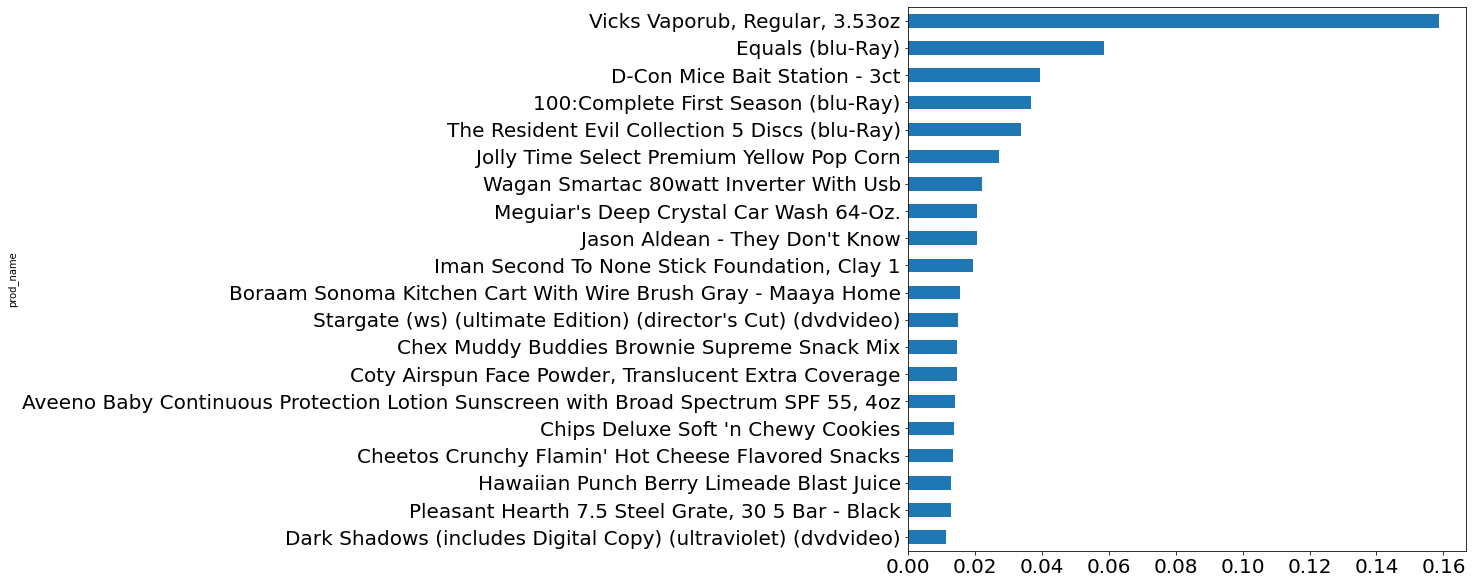

In [181]:
# 10 popular products (from 304 unique products, 3681 rows)
d_item1.plot(kind = 'barh', figsize=[10,10], fontsize=20).invert_yaxis()

In [182]:
d_item2 = pd.merge(d_item1,df_new,left_on='prod_name',right_on='prod_name',how = 'left')
d_item2.head()

,prod_name,00sab00,prod_id,brand,categories,manufacturer,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review,word_cnt
0,"Vicks Vaporub, Regular, 3.53oz",0.158717,AVpfRoqcLJeJML436FqG,Vicks,"Personal Care,Medicine Cabinet,Cough/Cold,Health,Cough, Cold & Flu,Health & Beauty,Health Care,Over-the-Counter Medicine,Health & Household,Medications & Treatments,Cough & Cold,Chest Rubs,Health & Wellness,Allergy & Sinus",P&G,2017-03-01T00:00:00.000Z,False,False,1,What have you done to Vicks I have used this product for many years and it is not the same nor does it work as well. The vapor feeling is gone and it does not clear my head like it did in the past.,Disappointed,blueyes,0,disappoint what do vicks i use product many year work well the vapor feel go clear head like past,19
1,"Vicks Vaporub, Regular, 3.53oz",0.158717,AVpfRoqcLJeJML436FqG,Vicks,"Personal Care,Medicine Cabinet,Cough/Cold,Health,Cough, Cold & Flu,Health & Beauty,Health Care,Over-the-Counter Medicine,Health & Household,Medications & Treatments,Cough & Cold,Chest Rubs,Health & Wellness,Allergy & Sinus",P&G,2017-02-07T00:00:00.000Z,False,False,1,My husband picked this up for me when I was sick and didn't realize it was lemon scented. It was effective but the smell was very strong and left me feeling like I needed to go clean something rather than relaxed. The smell of Vicks is a bit nostalgic and brings comfort. The lemon scent is not r...,Effective but makes me want to wax my furniture,lmdec,0,effective make want wax furniture my husband pick i sick realize lemon scent it effective smell strong leave feeling like i need go clean something rather relax the smell vicks bite nostalgic brings comfort the lemon scent relax all if want try new scent maybe lavender would better,48
2,"Vicks Vaporub, Regular, 3.53oz",0.158717,AVpfRoqcLJeJML436FqG,Vicks,"Personal Care,Medicine Cabinet,Cough/Cold,Health,Cough, Cold & Flu,Health & Beauty,Health Care,Over-the-Counter Medicine,Health & Household,Medications & Treatments,Cough & Cold,Chest Rubs,Health & Wellness,Allergy & Sinus",P&G,2016-11-17T00:00:00.000Z,False,False,1,"Like others who have posted, something has definitely changed with VapoRub. It doesn't smell as strong. It has been posted that the formula hasn't changed but all of us couldn't be wrong. The nose knows. And while I'm writing, please bring back VapoCream. It was so much more pleasant to use. Had...",Bring Back the Old Formula,patski107,0,bring back old formula like others post something definitely change vaporub it smell strong it post formula change us wrong the nose know and im write please bring back vapocream it much pleasant use have i know go discontinue year ago i would buy case pat,46
3,"Vicks Vaporub, Regular, 3.53oz",0.158717,AVpfRoqcLJeJML436FqG,Vicks,"Personal Care,Medicine Cabinet,Cough/Cold,Health,Cough, Cold & Flu,Health & Beauty,Health Care,Over-the-Counter Medicine,Health & Household,Medications & Treatments,Cough & Cold,Chest Rubs,Health & Wellness,Allergy & Sinus",P&G,2016-10-02T00:00:00.000Z,False,False,1,I only put one star because I had to. Will not buy your product unless you go back to the original ingredients that work. I paid a lot of money for this and threw it out it did not work and smelled horrible. Soooooooo disappointed.,does not work or smell good want the original Vicm,debd,0,work smell good want original vicm i put one star i to will buy product unless go back original ingredient work i pay lot money throw work smell horrible soooooooo disappoint,31
4,"Vicks Vaporub, Regular, 3.53oz",0.158717,AVpfRoqcLJeJML436FqG,Vicks,"Personal Care,Medicine Cabinet,Cough/Cold,Health,Cough, Cold & Flu,Health & Beauty,Health Care,Over-the-Counter Medicine,Health & Household,Medications & Treatments,Cough & Cold,Chest Rubs,Health & Wellness,Allergy & Sinus",P&G,2016-08-12T00:00:00.000Z,False,False,1,"I've read a response from Vicks to another reviewer that stated there h

### Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user. 

In [183]:
test_rc.columns

Index(['prod_id', 'brand', 'categories', 'manufacturer', 'prod_name',
       'reviews_date', 'reviews_didPurchase', 'reviews_doRecommend',
       'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_username',
       'user_sentiment', 'review', 'word_cnt'],
      dtype='object')

In [184]:
common =  test_rc[test_rc.prod_name.isin(train_rc.prod_name)]
common.shape

(5439, 15)

In [185]:
common.head(4)

,prod_id,brand,categories,manufacturer,prod_name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review,word_cnt
24423,AVpfR5m0LJeJML436K3W,Warner Music Group,"Music on CD or Vinyl,Country Music on CD or Vinyl,Contemporary Country Music on CD or Vinyl,Movies, Music & Books,Music,Country,CDs & Vinyl,CDs,Movies & Music,Music (CDs & Vinyl),Pop,Contemporary Country",Broken Bow,Jason Aldean - They Don't Know,2016-10-07T00:00:00.000Z,na,True,5,Aldean puts a little jam in country and tells some good stories.,Keeps churning out the hits,cincybbreviewer,1,keep churn hit aldean put little jam country tell good story,11
26145,AVpfUJu_ilAPnD_xZdDr,Chobani,"Food & Beverage,Fresh Food,Dairy,Yogurt,Food & Beverage Ways To Shop,Special Diets,Featured Brands,Grocery,Yogurt Snacks,Food,Dairy, Eggs & Cheese,Yogurt & Yogurt Drinks,Greek Yogurt,Computers Features,Greek & Strained Flavored Yogurt",Chooka,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,2015-09-20T00:00:00.000Z,False,True,4,I like the idea that the fruit is on the bottom and you can whip it up yourself. This took some discovery.,Chobani Strawberry Yogurt,racewalker26,1,chobani strawberry yogurt i like idea fruit bottom whip yourself this take discovery,13
20236,AVpf--o9LJeJML43G_Fq,Vaseline,"Personal Care,Skin Care,Hand Cream,Beauty,Body Lotions & Creams,Featured Brands,Health & Beauty,Unilever,Holiday Shop,Christmas,Bath & Body,Hand Creams & Lotions,Nail Care, Manicure & Pedicure,Hand & Nail Treatment Creams,Moisturizers",Vaseline,Vaseline Intensive Care Healthy Hands Stronger Nails,2015-02-22T00:00:00.000Z,False,True,5,"This is an excellent hand lotion!!! It makes my hands so soft, I carry it everywhere I go and I have some on my desks at work and home. I just wish it came in a larger size like it use to",Excellent Product,belle,1,excellent product this excellent hand lotion it make hand soft i carry everywhere i go i desks work home i wish come large size like use,26
14537,AVpf4oLxLJeJML43FcxC,Avery,"Office,Office Supplies,Office Organization,Binders and Accessories,All Binders,School & Office Supplies,Filing,File Dividers,Dividers",Avery Dennison,"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",2009-08-25T00:00:00.000Z,False,True,5,"As soon as I got my Double Column Table of Contents I put it to work. I use it for client account profiles. Everything is convenient in one binder right at my finger tips. As my client list increases, I will change to the 32 tab system. The printing instructions were clear and I did it correctly...",Great Double Column Table of Contents System !!,girlfriday,1,great double column table content system as soon i get double column table content i put work i use client account profile everything convenient one binder right finger tip as client list increase i change tab system the printing instruction clear i correctly first attempt that real plus me i di...,66


In [186]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='prod_name', values='reviews_rating').T

In [187]:
common_item_based_matrix.shape

(132, 5191)

In [188]:
item_correlation_df = pd.DataFrame(item_correlation)

In [189]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [190]:
item_correlation_df['prod_name'] = df_subtracted.index
item_correlation_df.set_index('prod_name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197
prod_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009437,0.0,0.0,0.0,0.0,0.0,0.002772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008855,0.0,0.0,0.0,0.0,0.009301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000

In [191]:
list_name = common.prod_name.tolist()

In [192]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [193]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [194]:
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","Iman Second To None Stick Foundation, Clay 1","J.R. Watkins Hand Cream, Lemon Cream",Jason Aldean - They Don't Know,"Jergens Extra Moisturizing Liquid Hand Wash, 7.5oz","Johnson's Baby Bubble Bath and Wash, 15oz",Jolly Time Select Premium Yellow Pop Corn,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",K-Y Love Sensuality Pleasure Gel,Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,Kraus FVS-1007 Single Hole Vessel Bathroom Faucet from the Ramus Collection,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,L'oreal Paris Advanced Hairstyle Boost It High Lift Creation Spray,"L'oreal Paris Colour Caresse Wet Shine Stain, Pink Resistance","L'oreal Paris Visible Lift Smooth Absolute, Natural Buff",Leslie Sansone:Belly Blasting Walk (dvd),Little Bedding By Nojo Jungle Dreams 2 Pack Sheet Set,"Lysol Concentrate Deodorizing Cleaner, Original Scent",Maranatha No Stir Raw Maple Almond Butter,Meguiar's Deep Crystal Car Wash 64-Oz.,Meguiar's Ultimate Quik Detailer 22-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Mrs. Meyer's Lemon Verbena Surface Scrub,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,"Musselman Apple Sauce, Cinnamon, 48oz",My Big Fat Greek Wedding

In [195]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e+00, 1.10880487e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.65067423e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.78949229e-03, 0.00000000e+00, 7.42151465e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.98576092e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [196]:
common_item_predicted_ratings.shape

(132, 5191)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train



In [197]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='prod_name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.


In [198]:
common_ = common.pivot_table(index='reviews_username', columns='prod_name', values='reviews_rating').T

In [199]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [ 1. nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [200]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [201]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5891535877013956


### Comment about recommendation system
- I will select `item-item` based recommendation system as for `user-user` item matrix doesn't have review for all the products.

In [202]:
#Pickle the item item recomendation 

pickle.dump(item_final_rating, open("pickle/recommendation_model.pkl", "wb"))

## 8. Combining both model and predict top 5 product recommendation for a user

In [203]:
# Select the review from mereged dataframe 
X1=d_item2['review']

# Load the word vectorizer
vectorizer = pickle.load(open("pickle/vector.pkl", "rb"))

# Transform the X1
X1_trans = vectorizer.transform(X1.tolist())

In [204]:
#Load the sentiment classification model
model = pickle.load(open("pickle/sentiment_model_LR.pkl", "rb"))

#make the prediction
pred_sent= model.predict(X1_trans)

In [205]:
#prediction array

pred_sent

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [206]:
#add the prediction to dataframe

d_item2['sent_predicated'] = pred_sent

d_item2.head(2)

,prod_name,00sab00,prod_id,brand,categories,manufacturer,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review,word_cnt,sent_predicated
0,"Vicks Vaporub, Regular, 3.53oz",0.158717,AVpfRoqcLJeJML436FqG,Vicks,"Personal Care,Medicine Cabinet,Cough/Cold,Health,Cough, Cold & Flu,Health & Beauty,Health Care,Over-the-Counter Medicine,Health & Household,Medications & Treatments,Cough & Cold,Chest Rubs,Health & Wellness,Allergy & Sinus",P&G,2017-03-01T00:00:00.000Z,False,False,1,What have you done to Vicks I have used this product for many years and it is not the same nor does it work as well. The vapor feeling is gone and it does not clear my head like it did in the past.,Disappointed,blueyes,0,disappoint what do vicks i use product many year work well the vapor feel go clear head like past,19,0
1,"Vicks Vaporub, Regular, 3.53oz",0.158717,AVpfRoqcLJeJML436FqG,Vicks,"Personal Care,Medicine Cabinet,Cough/Cold,Health,Cough, Cold & Flu,Health & Beauty,Health Care,Over-the-Counter Medicine,Health & Household,Medications & Treatments,Cough & Cold,Chest Rubs,Health & Wellness,Allergy & Sinus",P&G,2017-02-07T00:00:00.000Z,False,False,1,My husband picked this up for me when I was sick and didn't realize it was lemon scented. It was effective but the smell was very strong and left me feeling like I needed to go clean something rather than relaxed. The smell of Vicks is a bit nostalgic and brings comfort. The lemon scent is not r...,Effective but makes me want to wax my furniture,lmdec,0,effective make want wax furniture my husband pick i sick realize lemon scent it effective smell strong leave feeling like i need go clean something rather relax the smell vicks bite nostalgic brings comfort the lemon scent relax all if want try new scent maybe lavender would better,48,0


In [207]:
# Groupby product name and use mean value of review predicted to get the average sentiment for each product

d3 = d_item2.groupby('prod_name').sent_predicated.mean()

In [208]:
d3

prod_name
100:Complete First Season (blu-Ray)                                                   1.000000
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz    1.000000
Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home                          0.888889
Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks                                    0.983333
Chex Muddy Buddies Brownie Supreme Snack Mix                                          0.965517
Chips Deluxe Soft 'n Chewy Cookies                                                    0.666667
Coty Airspun Face Powder, Translucent Extra Coverage                                  0.949367
D-Con Mice Bait Station - 3ct                                                         0.428571
Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)                         0.950820
Equals (blu-Ray)                                                                      0.916667
Hawaiian Punch Berry Limeade Blast Juice

In [209]:
#Merge the above with top20 data and sort by review predicted 

d4= (pd.merge(d_item1,d3,left_on='prod_name',right_on='prod_name',how = 'left').sort_values(by='sent_predicated',ascending=False))

#convert the review predicted into percentage value
d4['sent_predicated'] = round(d4['sent_predicated']*100,2)
d4

,00sab00,sent_predicated
prod_name,,
"Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",0.014103,100.00
"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",0.012874,100.00
100:Complete First Season (blu-Ray),0.036760,100.00
Jolly Time Select Premium Yellow Pop Corn,0.027359,100.00
Hawaiian Punch Berry Limeade Blast Juice,0.013048,100.00
Meguiar's Deep Crystal Car Wash 64-Oz.,0.020834,100.00
Jason Aldean - They Don't Know,0.020702,99.00
The Resident Evil Collection 5 Discs (blu-Ray),0.033735,98.93
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),0.014951,98.39


In [210]:
# convert into dataframe and reset index. Select only top 5 products with highest positive sentiments%

df5 = pd.DataFrame(d4[:5]).reset_index()

In [211]:
#select only product name and rename column

df6 = pd.DataFrame(df5['prod_name'])
df6 = df6.rename(columns={"prod_name": "Product Name"})
print('Top 5 products for user:-') 
df6

Top 5 products for user:-


,Product Name
0,"Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz"
1,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black"
2,100:Complete First Season (blu-Ray)
3,Jolly Time Select Premium Yellow Pop Corn
4,Hawaiian Punch Berry Limeade Blast Juice
